In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from risk_measure import *

# Risk Measure
### What is a risk measure?
A risk measure works like a score for an exposure. If an exposure has a higher risk, the risk measure should be higher. However, this depends on the properties of risk measures. One of the very popular risk measures is the standard deviation but it does not have the transition invariance property, which is a property that if a certain amount is added to the exposure, the risk measure is deducted by that amount (read more at [Wikipedia](https://en.wikipedia.org/wiki/Coherent_risk_measure)).
### Quantile Function
The quantile function is a risk measure that gives the probability that a random valiable is less than a certain value. In other words, it is the inverse cumulative distribution function of a random variable.
Given that
$$ F_X (x) \coloneqq P(X<x)$$
The quantile function is
$$ Q(p) = F_X^{-1} (p)$$
### Value at Risk
Value at risk (V@R) determines the minimum value that a random variable can fall lower under a certain probability ($1-\alpha$). Note that there are various definitions for V@R and this is just a simplified version.
$$ \text{VaR}_\alpha (X) = -\text{inf}\{x \in \mathbb{R} : F_X (x) > \alpha \} = F_{-X}^{-1} (1-\alpha) $$
### Expected Shortfall
Expected shortfall is a risk measure which estimates the average loss of a random variable. The average loss is the losses at least at the V@R. This means the expected shortfall includes all possibble losses beyond the V@R. 
$$ \text{ES}_\alpha (X) = \text{E}[-X | X\le-\text{VaR}_\alpha (X)]  = \frac{1}{1-\alpha} \int_\alpha^1 \text{VaR}_s (X) ds = \frac{1}{1-\alpha} \left(-\text{E}[X \cdot 1_{\{X\le-\text{VaR}_\alpha (X)\}}] + \text{VaR}_\alpha (X)(\text{P}(X \le x_\alpha) - \alpha)\right)$$

Note that: $\alpha$ in this place is the left-tail risk and $\alpha = $ 1 - the confident level

In [2]:
# CDF
%psource RiskMeasure.NonParametric.CDF

        def CDF(self, x):
            data = np.array(self._data)
            sortedData = np.sort(data)

            arangeData = np.arange(len(data))
            percentileSortedData = arangeData/(len(data)-1) # len(data) - 1 because we count the first sample as the 0th percentile
            
            if max(sortedData) <= x:
                position = 1.0

            elif min(sortedData) > x:
                position = 0.0

            else:
                for i in range(1, len(data) + 1):
                    if (sortedData[i] > x): # This condition checks the next position
                        partialPart = (x-sortedData[i-1])/(sortedData[i] - sortedData[i-1])*(percentileSortedData[i] - percentileSortedData[i-1]) # assume that the risk between two samples is linear
                        integerIndex = i - 1
                        position = percentileSortedData[integerIndex] + partialPart
                        break
                    
                    elif (sorte

In [3]:
# Value At Risk
%psource RiskMeasure.NonParametric.valueAtRisk
# note that we can just simply use .quantile for the value at risk
# For example: pd.DataFrame([sample]).quantile([alpha], interpolation="linear")

        def valueAtRisk(self, alpha):
            data = np.array(self._data)
            sortedData = np.sort(data)
            
            arangeData = np.arange(len(data))
            percentileSortedData = arangeData/(len(data)-1)

            if max(percentileSortedData) <= alpha: # max(percentileSortedData) is 1
                integer = len(data) - 1
                partial = 0
                sortedData = np.append(sortedData, sortedData[-1])

            elif min(percentileSortedData) >= alpha:
                integer = 0 # This is because we do not know the minimum value, so we assume that the minimum value is the smallest sample
                partial = 0

            else:
                for i in range(1,len(data)):
                    if (percentileSortedData[i] > alpha):
                        partial = (alpha-percentileSortedData[i-1])/(percentileSortedData[i] - percentileSortedData[i-1]) # assume that the risk between two samples is uniform
                        i

In [4]:
# Expected Shortfall
%psource RiskMeasure.NonParametric.expectedShortfall

        def expectedShortfall(self, alpha):
            data = np.array(self._data)
            sortedData = np.sort(data)

            valueAtRisk = self.valueAtRisk(alpha)

            probLeftRisk = len(sortedData[sortedData <= valueAtRisk])/len(sortedData)
            for i in range(1,len(sortedData)):
                if (sortedData[i] > valueAtRisk):
                    partialProbLeftRisk = (valueAtRisk - sortedData[i-1])/(sortedData[i] - sortedData[i-1]) * ( 1 / len(sortedData) )
                    partialProbRightRisk = (sortedData[i] - valueAtRisk)/(sortedData[i] - sortedData[i-1]) * ( 1 / len(sortedData) )
                    break
                
                elif (sortedData[i] == valueAtRisk):
                    partialProbLeftRisk = 0
                    partialProbRightRisk = 0
                    break
                
            numerator = (-np.sum(sortedData[sortedData <= valueAtRisk])/len(sortedData) - (valueAtRisk * partialProbRightRisk) ) + ( valueAtRisk * 

# Application

Let's build paths of a stock using Geometric Brownian motion

where $\mu$ is the drift and $\sigma$ is the diffusion of the model

### GBM

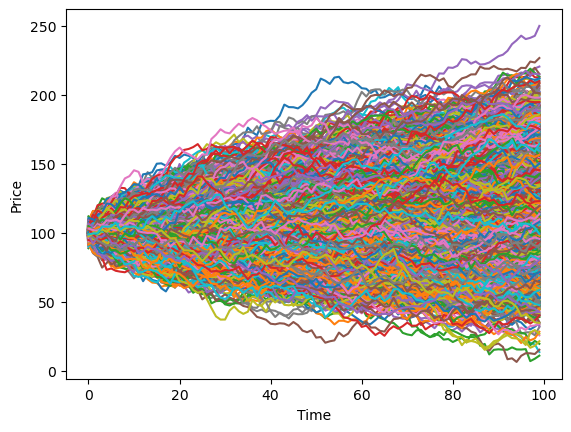

In [5]:
np.random.seed(42)
mu = 0.2
sigma = 0.3
S_0 = 100
time_horizon = 1
num_step = 100
num_path = 5000
dt = time_horizon/num_step
simu_size = (num_path,num_step) 

start = np.ones(shape=(num_path,1))*S_0
norm_rand = np.random.normal(loc=0.0, scale=1.0, size=simu_size)
ds = (mu*dt + sigma * dt**(0.5) * norm_rand)*S_0
GBM = np.cumsum(ds,axis=1) + S_0

plt.plot(GBM[:,:].T)
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [6]:
CDF = RiskMeasure.NonParametric(GBM[:,-1]).CDF(90)
VaR = RiskMeasure.NonParametric(GBM[:,-1]).valueAtRisk(0.05)
ExpectedShortfall = RiskMeasure.NonParametric(GBM[:,-1]).expectedShortfall(0.05)

print("The cdf of the simulation for the stock to have value at 80 is ",CDF)
print("The value at risk of the simulating stock at alpha = 0.05 is ", VaR)
print("The expected shortfall of the simulating stock at alpha = 0.05 is ", ExpectedShortfall)

The cdf of the simulation for the stock to have value at 80 is  0.16532794386567717
The value at risk of the simulating stock at alpha = 0.05 is  69.9910508075334
The expected shortfall of the simulating stock at alpha = 0.05 is  56.82583829991943


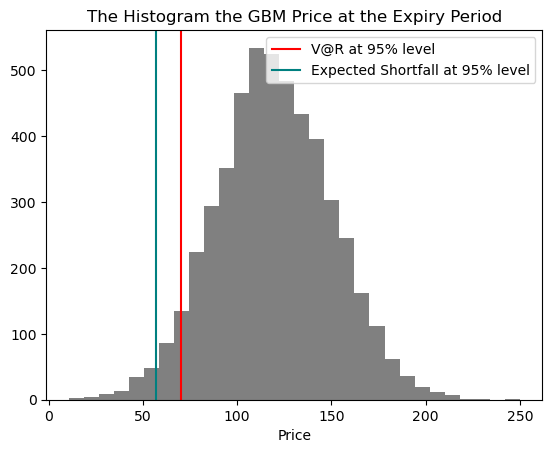

In [7]:
plt.hist(x = GBM[:,-1], bins=30, color="grey")
plt.title("The Histogram the GBM Price at the Expiry Period")
plt.xlabel("Price")
plt.axvline(x = VaR, color="red", label = "V@R at 95% level")
plt.axvline(x = ExpectedShortfall, color="teal", label = "Expected Shortfall at 95% level")
plt.legend()
plt.show()